<center><h1>Py-Galaxies examples</h1></center>

## Import modules

In [1]:
import PyGalaxies
import time
import numpy as np


model_param_filepath='Input_Params/input_params.yml'
debug_flag = False
verbosity = 1 
time_code = True

## Get model params and print

In [2]:
model_params = PyGalaxies.ModelParams(model_param_filepath,verbosity,debug_flag)
model_params.output_params()

input_files         : {'graph_file': '../Input Data/mega_graph_latest.hdf5'}
output_files        : {'halo_file': '../Output Data/SMT13HaloOutput.hdf5', 'galaxy_file': '../Output Data/SMT13GalaxyOutput.hdf5'}
cosmology           : {'omega_m': {'Description': 'Matter density parameter', 'Value': 0.3, 'Units': 'None'}, 'f_baryon': {'Description': 'Baryon fraction', 'Value': 0.155, 'Units': 'None'}}
model_switches      : {'HOD': {'Description': 'Halo occupation description for stars (as primitive test)', 'Value': True}, 'sub_halo': {'Description': 'For each graph, load in Sub-halo data?', 'Value': False}}
performance         : {'io_nRec': {'Description': 'Size of HDF5 io buffer (number of records)', 'Value': 1000}}


## Run baryon fraction calculations and output

In [3]:
# Open the input HDF5 file containing graph groups and create an output file.
HDF_properties = PyGalaxies.HDFProperties(model_params)



start_time = time.time()


for graph_ID in range(0,HDF_properties.no_of_graphs)[:]:
    
    if verbosity >= 2: print('Processing graph',graph_ID)
    

    graph_properties = PyGalaxies.GraphProperties(graph_ID,
                                       HDF_properties.graph_input_file,
                                       model_params,
                                       HDF_properties.part_mass)
    
    
    array_of_halo_properties = np.empty(len(graph_properties.graph_halo_ids),
                                        dtype = object)

        
    for snap_ID in graph_properties.generation_id:
        

        if graph_properties.generation_start_index[snap_ID] == 2**30:
            continue
    
        
        this_generation_halo = graph_properties.graph_halo_ids[
                               graph_properties.generation_start_index[snap_ID]:
                               graph_properties.generation_start_index[snap_ID] + 
                               graph_properties.generation_length[snap_ID]]
        
        for halo_ID in this_generation_halo:
            
            halo = PyGalaxies.HaloProperties(str(graph_ID),snap_ID,halo_ID,
                                  graph_properties,HDF_properties.part_mass)
        
        
        
            PyGalaxies.inclusive_mass_contribution(halo)
            
            
            if halo.nprog > 0: 
                PyGalaxies.gather_progenitors(halo,HDF_properties.part_mass)
            else:
                halo.mass_from_progenitors = 0.
                

            PyGalaxies.set_baryon_fraction(halo,array_of_halo_properties,model_params.f_baryon)
            
            halo.done=True
            
            array_of_halo_properties[halo_ID] = halo

            HDF_properties.n_halo +=1 

    # Save output
    HDF_properties.output_halos(array_of_halo_properties)




# Close input file
HDF_properties.close_graph_io(HDF_properties.graph_input_file)


# Close output files
if HDF_properties.halo_output_iRec > 0: 

    halo_output_iRec = HDF_properties.flush_output()
    
HDF_properties.close_graph_io(HDF_properties.halo_output_file)


end_time = time.time()
print('This took {} seconds'.format(end_time-start_time))

This took 15.87761402130127 seconds


## Generate baryon fraction plots


In [7]:
halo_param_file ='input_params/halo_plot_params.yml'

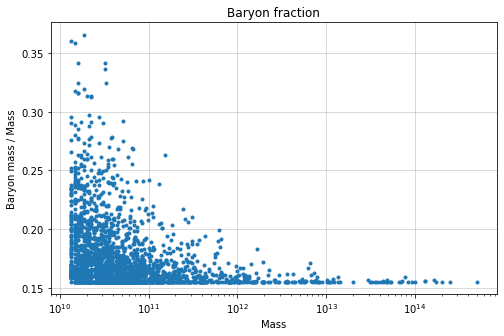

In [8]:
plot_halos = PyGalaxies.PlotHalos(halo_param_file) # Loads in params and filters

plot_halos.generate_plots()